# <b>LSTM on Amazon Alexa Reviews Dataset<b>


---



In [ ]:
# !pip install tensorflow
import pandas as pd    # to load dataset
import numpy as np     # for mathematic equation
from nltk.corpus import stopwords   # to get collection of stopwords
from sklearn.model_selection import train_test_split       # for splitting dataset
from tensorflow.keras.preprocessing.text import Tokenizer  # to encode text to int
from tensorflow.keras.preprocessing.sequence import pad_sequences   # to do padding or truncating
from tensorflow.keras.models import Sequential     # the model
from tensorflow.keras.layers import Embedding, LSTM, Dense # layers of the architecture
from tensorflow.keras.callbacks import ModelCheckpoint   # save model
from tensorflow.keras.models import load_model   # load saved model
import re

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/drive')
data=pd.read_csv("/drive/My Drive/Sem 6/SGP IV/dataset/amazon_alexa.csv",sep=',')
data

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


,rating,date,variation,verified_reviews,feedback,verified_reviews_clean
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,love echo
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,love it
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,sometimes play game answer question correctly ...
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,lot fun thing yr old learn dinosaur control li...
4,5,31-Jul-18,Charcoal Fabric,Music,1,music
...,...,...,...,...,...,...
2430,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1,love thing run entire home tv light thermostat...
2431,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1,complaint sound quality great mostly use comma...
2432,4,29-Jul-18,Black Dot,Good,1,good
2433,5,29-Jul-18,Black Dot,Nice little unit no issues,1,nice little unit issue


#Preprocessing Data

In [ ]:
import nltk
nltk.download('stopwords')
english_stops = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#Encode Sentiments


In [ ]:
def load_dataset():
    df = pd.read_csv("/drive/My Drive/Sem 6/SGP IV/dataset/amazon_alexa.csv")
    x_data = df['verified_reviews']       # Reviews/Input
    y_data = df['feedback']    # Sentiment/Output

    # PRE-PROCESS REVIEW
    x_data = x_data.replace({'<.*?>': ''}, regex = True)          # remove html tag
    x_data = x_data.replace({'[^A-Za-z]': ' '}, regex = True)     # remove non alphabet
    x_data = x_data.apply(lambda review: [w for w in review.split() if w not in english_stops])  # remove stop words
    x_data = x_data.apply(lambda review: [w.lower() for w in review])   # lower case
    
    # ENCODE SENTIMENT -> 0 & 1
    y_data = y_data.replace('positive', 1)
    y_data = y_data.replace('negative', 0)

    return x_data, y_data

x_data, y_data = load_dataset()

print('Reviews')
print(x_data, '\n')
print('Sentiment')
print(y_data)

Reviews
0                                            [love, echo]
1                                                 [loved]
2       [sometimes, playing, game, answer, question, c...
3       [i, lot, fun, thing, my, yr, old, learns, dino...
4                                                 [music]
                              ...                        
2430    [i, love, things, running, entire, home, tv, l...
2431    [only, complaint, i, sound, quality, great, i,...
2432                                               [good]
2433                         [nice, little, unit, issues]
2434    [the, echo, dot, easy, set, use, it, helps, pr...
Name: verified_reviews, Length: 2435, dtype: object 

Sentiment
0       1
1       1
2       1
3       1
4       1
       ..
2430    1
2431    1
2432    1
2433    1
2434    1
Name: feedback, Length: 2435, dtype: int64


#Split Dataset

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.25)

print('Train Set')
print(x_train, '\n')
print(x_test, '\n')
print('Test Set')
print(y_train, '\n')
print(y_test)

Train Set
2342                                 [i, addicted, thing]
2395                    [i, live, alone, best, companion]
499     [now, i, weary, picking, conversations, active...
515     [loved, price, essentially, brand, new, dot, o...
1663                                     [not, available]
                              ...                        
1686                                     [not, available]
352                  [works, great, different, new, ones]
2069    [great, device, i, cutting, cable, watching, c...
523     [great, price, works, perfectly, saved, money,...
1709    [so, convenient, i, never, touch, remote, shut...
Name: verified_reviews, Length: 1826, dtype: object 

347       [great, sound, size, prize, and, course, alexa]
1707    [love, echo, everywhere, i, go, house, always,...
490     [love, two, echo, dots, third, one, ordered, g...
411                                 [everything, perfect]
776     [i, love, able, alexa, sing, careless, whisper...
        

In [ ]:
def get_max_length():
    review_length = []
    for review in x_train:
        review_length.append(len(review))

    return int(np.ceil(np.mean(review_length)))

#Tokenize and Pad/Truncate Reviews

In [ ]:
# ENCODE REVIEW
token = Tokenizer(lower=False)    # no need lower, because already lowered the data in load_data()
token.fit_on_texts(x_train)
x_train = token.texts_to_sequences(x_train)
x_test = token.texts_to_sequences(x_test)

max_length = get_max_length()

x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')

total_words = len(token.word_index) + 1   # add 1 because of 0 padding

print('Encoded X Train\n', x_train, '\n')
print('Encoded X Test\n', x_test, '\n')
print('Maximum review length: ', max_length)

Encoded X Train
 [[   1 1044   43 ...    0    0    0]
 [   1  354  534 ...    0    0    0]
 [ 222    1 1803 ...    1  106   14]
 ...
 [   4   22    1 ...  235   93    6]
 [   4   77   11 ...    0    0    0]
 [  61  270    1 ...    0    0    0]] 

Encoded X Test
 [[   4   16  132 ...    0    0    0]
 [   2    3 1202 ...    0    0    0]
 [   2   94    3 ...  480  583   29]
 ...
 [   4   19   40 ...   23   26  212]
 [   1  512  118 ...    0    0    0]
 [  31    6   42 ...    0    0    0]] 

Maximum review length:  15


#Build Model

In [ ]:
# ARCHITECTURE
EMBED_DIM = 32
LSTM_OUT = 64

model = Sequential()
model.add(Embedding(total_words, EMBED_DIM, input_length = max_length))
model.add(LSTM(LSTM_OUT))
model.add(Dense(1, activation='relu'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 15, 32)            111360    
                                                                 
 lstm_4 (LSTM)               (None, 64)                24832     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 136,257
Trainable params: 136,257
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
checkpoint = ModelCheckpoint(
    'models/LSTM.h5',
    monitor='accuracy',
    save_best_only=True,
    verbose=1
)

In [ ]:
model.fit(x_train, y_train, batch_size = 128, epochs = 5, callbacks=[checkpoint])


Epoch 1/5
15/15 [==============================] - ETA: 0s - loss: 3.7899 - accuracy: 0.0915
Epoch 1: accuracy improved from -inf to 0.09146, saving model to models/LSTM.h5
15/15 [==============================] - 4s 31ms/step - loss: 3.7899 - accuracy: 0.0915
Epoch 2/5
15/15 [==============================] - ETA: 0s - loss: 1.7147 - accuracy: 0.0915
Epoch 2: accuracy did not improve from 0.09146
15/15 [==============================] - 1s 42ms/step - loss: 1.7147 - accuracy: 0.0915
Epoch 3/5
15/15 [==============================] - ETA: 0s - loss: 1.0926 - accuracy: 0.1353
Epoch 3: accuracy improved from 0.09146 to 0.13527, saving model to models/LSTM.h5
15/15 [==============================] - 1s 45ms/step - loss: 1.0926 - accuracy: 0.1353
Epoch 4/5
14/15 [===========================>..] - ETA: 0s - loss: 0.5384 - accuracy: 0.8594
Epoch 4: accuracy improved from 0.13527 to 0.85980, saving model to models/LSTM.h5
15/15 [==============================] - 1s 45ms/step - loss: 0.5468 - 

In [ ]:
y_pred = (model.predict(x_test) > 0.5).astype("int32")


true = 0
for i, y in enumerate(y_test):
    if y == y_pred[i]:
        true += 1

print('Correct Prediction: {}'.format(true))
print('Wrong Prediction: {}'.format(len(y_pred) - true))
print('Accuracy: {}'.format(true/len(y_pred)*100))

model.save('LSTM.h5')

20/20 [==============================] - 1s 6ms/step
Correct Prediction: 555
Wrong Prediction: 54
Accuracy: 91.13300492610837


In [ ]:
loaded_model = load_model('/content/LSTM.h5')


In [ ]:
review = str(input('Enter Review: '))

Enter Review: Writing this review after 7 months of usage I have bought nearly 7 to 8 models in redmi before few budget and few note series. This is the worst phone i used in terms of performance and touch  Note: I bought it for my parents - > No apps installed other than watsapp(very minimal usage only they will see receiving messages), only it has default apps which cant be uninstalled, only usage in this mobile is calls, and occasionally watching youtube  Pros: Good battery life. Cons: * Touch is not responds most of the times after 2-3 months of usage, even you can access touch in some important situations while attending incoming call, while unlocking, you have to lock screen using power button 3-4 times and try again to make touch respond. - * Very lag sometimes - it is happening after 2-3 month usage. * Sometime network reception is bad


In [ ]:
# Pre-process input
regex = re.compile(r'[^a-zA-Z\s]')
review = regex.sub('', review)
print('Cleaned: ', review)

words = review.split(' ')
filtered = [w for w in words if w not in english_stops]
filtered = ' '.join(filtered)
filtered = [filtered.lower()]

print('Filtered: ', filtered)

Cleaned:  Writing this review after  months of usage I have bought nearly  to  models in redmi before few budget and few note series This is the worst phone i used in terms of performance and touch  Note I bought it for my parents   No apps installed other than watsappvery minimal usage only they will see receiving messages only it has default apps which cant be uninstalled only usage in this mobile is calls and occasionally watching youtube  Pros Good battery life Cons  Touch is not responds most of the times after  months of usage even you can access touch in some important situations while attending incoming call while unlocking you have to lock screen using power button  times and try again to make touch respond   Very lag sometimes  it is happening after  month usage  Sometime network reception is bad
Filtered:  ['writing review  months usage i bought nearly   models redmi budget note series this worst phone used terms performance touch  note i bought parents   no apps installed w

In [ ]:
tokenize_words = token.texts_to_sequences(filtered)
tokenize_words = pad_sequences(tokenize_words, maxlen=max_length, padding='post', truncating='post')
print(tokenize_words)

[[2116  597  304 1499    1   24  886 1312 2383   26 1656   85   79 2805
   389]]


In [ ]:
result = loaded_model.predict(tokenize_words)
print(result)

1/1 [==============================] - 0s 416ms/step
[[0.67006457]]


In [ ]:
if result >= 0.7:
    print('positive')
else:
    print('negative')

negative


In [ ]:
import sklearn.metrics as met
cm = met.confusion_matrix(y_test,y_pred)

In [ ]:
cm

array([[  3,  51],
       [  3, 552]])

<Axes: >

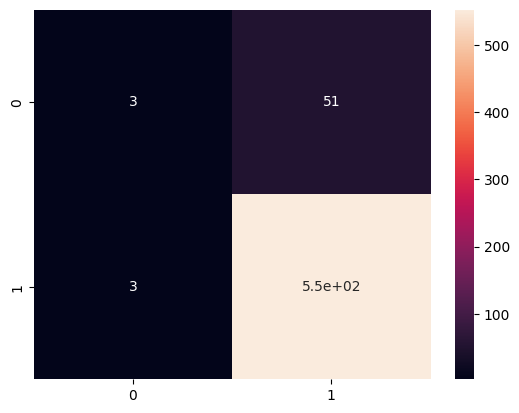

In [ ]:
import seaborn as sns
sns.heatmap(cm,annot=True)

In [ ]:
acc = met.accuracy_score(y_test,y_pred)
f1 = met.f1_score(y_test,y_pred)
prec = met.precision_score(y_test,y_pred)
recall = met.recall_score(y_test,y_pred)

In [ ]:
print('Accuracy Score: ',acc)
print('F1 Score: ',f1)
print('Precision: ',prec)
print('Recall: ',recall)

Accuracy Score:  0.9113300492610837
F1 Score:  0.9533678756476685
Precision:  0.9154228855721394
Recall:  0.9945945945945946


In [ ]:
max_length

15